In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/population-time-series-data/POP.csv
/kaggle/input/population-time-series-data/POPH.csv
/kaggle/input/population-time-series-data/national-population_metadata.json
/kaggle/input/population-time-series-data/total-population-all-ages-including-armed-forces-overseas_metadata.json


# Packages/Libraries to load 

In [2]:
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

# Define the task
The task is to predict the monthly Population. 

The data ranges from January 1952 to December 2019, with **816 observations.

In [3]:
df_POP = pd.read_csv('/kaggle/input/population-time-series-data/POP.csv', delimiter=',')
df_POP.dataframeName = 'POP.csv'
print(df_POP.shape)

(816, 4)


In [4]:
df_POP.head(5)

,date,value,realtime_start,realtime_end
0,1952-01-01,156309.0,2019-08-23,2019-08-23
1,1952-02-01,156527.0,2019-08-23,2019-08-23
2,1952-03-01,156731.0,2019-08-23,2019-08-23
3,1952-04-01,156943.0,2019-08-23,2019-08-23
4,1952-05-01,157140.0,2019-08-23,2019-08-23


In [5]:
df_POP.tail(5)

,date,value,realtime_start,realtime_end
811,2019-08-01,329591.333,2019-08-23,2019-08-23
812,2019-09-01,329785.872,2019-08-23,2019-08-23
813,2019-10-01,329982.035,2019-08-23,2019-08-23
814,2019-11-01,330154.949,2019-08-23,2019-08-23
815,2019-12-01,330309.946,2019-08-23,2019-08-23


## Plot the time series

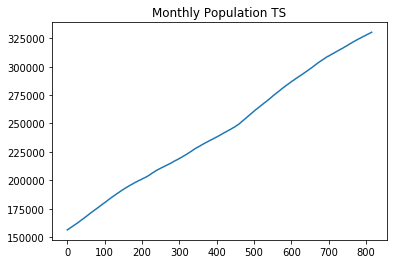

In [6]:
plt.title('Monthly Population TS')
plt.plot(df_POP['value'])
plt.show()

Converting Date to pandas DateTime for easier plotting of the Population TS data.

In [7]:
df_POP['date']=pd.to_datetime(df_POP['date'])

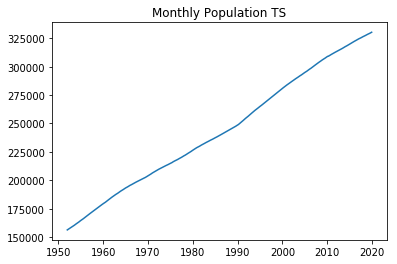

In [8]:
plt.title('Monthly Population TS')
plt.plot(df_POP['date'],df_POP['value'])
plt.show()

# Long Short-Term Memory network Network for Regression

Task: Given the Population number this month, what is the Population next month?

A function is used to convert the single column TS into a two-column dataset: 
* the first column containing this month’s (t) population count
* the second column containing next month’s (t+1) populations count, to be predicted.

> This notebook follows the Deep Learning for Time Series tutorial from Jason Brownlee (July 21, 2016). Link: https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/


In [9]:
# random seed for reproducibility
np.random.seed(5)

In [10]:
# reshape the dataset
dataset=np.array(df_POP['value'])
dataset=dataset.reshape(-1,1)

## Step 1 :  normalize the dataset

In [11]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

## Step 2 : Split the dataset into train and test sets

In [12]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

546 270


## Step 3 : reshape the train and test sets to 2 columns with t & t+1


In [13]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [14]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [15]:
# reshape input to [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

## Step 4 : create and fit the Long Short-Term Memory network

In [16]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 2s - loss: 0.0685
Epoch 2/100
 - 1s - loss: 0.0268
Epoch 3/100
 - 1s - loss: 0.0168
Epoch 4/100
 - 1s - loss: 0.0079
Epoch 5/100
 - 1s - loss: 0.0022
Epoch 6/100
 - 1s - loss: 3.5169e-04
Epoch 7/100
 - 1s - loss: 1.3706e-04
Epoch 8/100
 - 1s - loss: 1.2169e-04
Epoch 9/100
 - 1s - loss: 1.0875e-04
Epoch 10/100
 - 1s - loss: 9.5305e-05
Epoch 11/100
 - 1s - loss: 7.7700e-05
Epoch 12/100
 - 1s - loss: 6.5424e-05
Epoch 13/100
 - 1s - loss: 4.9810e-05
Epoch 14/100
 - 1s - loss: 3.7086e-05
Epoch 15/100
 - 1s - loss: 2.4508e-05
Epoch 16/100
 - 1s - loss: 1.5720e-05
Epoch 17/100
 - 1s - loss: 1.0499e-05
Epoch 18/100
 - 1s - loss: 6.6732e-06
Epoch 19/100
 - 1s - loss: 5.7272e-06
Epoch 20/100
 - 1s - loss: 5.0378e-06
Epoch 21/100
 - 1s - loss: 5.6401e-06
Epoch 22/100
 - 1s - loss: 5.0012e-06
Epoch 23/100
 - 1s - loss: 6.0639e-06
Epoch 24/100
 - 1s - loss: 5.4809e-06
Epoch 25/100
 - 1s - loss: 5.1489e-06
Epoch 26/100
 - 1s - loss: 5.9911e-06
Epoch 27/100
 - 1s - loss: 5.5525e-06
Epo

## Step 5 : Predictions & RMSE calculation

In [17]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 169.97 RMSE
Test Score: 2512.20 RMSE


## Step 6 : Plot of the population predictions

Original dataset in blue

Predictions for the training dataset in green

Predictions on the unseen test dataset in red


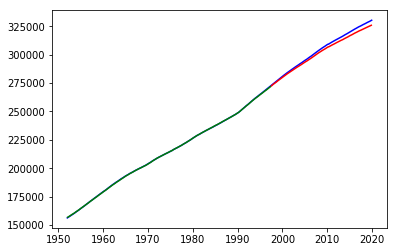

In [18]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(df_POP['date'],scaler.inverse_transform(dataset),color='blue')
plt.plot(df_POP['date'],trainPredictPlot,color='green')
plt.plot(df_POP['date'],testPredictPlot,color='red')
plt.show()

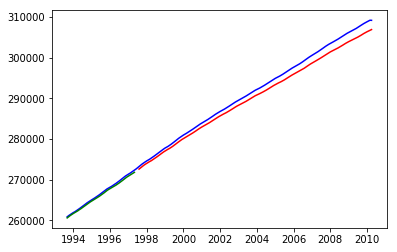

In [19]:
# plot baseline and predictions between 1994 & 2010
plt.plot(df_POP['date'][500:700],(scaler.inverse_transform(dataset))[500:700],color='blue')
plt.plot(df_POP['date'][500:700],trainPredictPlot[500:700],color='green')
plt.plot(df_POP['date'][500:700],testPredictPlot[500:700],color='red')
plt.show()